### Here we will first give a topic to the LLM, then it will automatically generate a post for twitter and it will be approved by a LLM if approved then it will end the loop otherwise it will be optimized then again will go for approval, if approved then it will be published otherwise again will be optimized and max turns will be 5 (we can change it as per out requirement)

In [4]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

from typing import TypedDict, Annotated, Literal
import operator
from dotenv import load_dotenv

from pydantic import BaseModel, Field

load_dotenv()

True

In [5]:
# Initialize Groq LLM
generator_llm = ChatGroq(model="llama-3.1-8b-instant")
evaluator_llm = ChatGroq(model="llama-3.1-8b-instant")
optimizer_llm = ChatGroq(model="llama-3.1-8b-instant")

In [6]:
## Creating the schme for evaluation
class TweetSchema(BaseModel):
    evaluation: Literal['approved', 'need_optimization'] = Field(..., description="Final evaluation")
    feedback: str = Field(..., description= "Fedback of the tweet")

In [8]:
## Structured model for evaluation
structured_evaluator_model = evaluator_llm.with_structured_output(TweetSchema)

In [10]:
## Creating state
class TweetState(TypedDict):
    topic: str
    tweet: str
    feedback: str
    evaluation: Literal['approved', 'need_optimization']
    iteration: int
    max_iteration: int

In [22]:
## Creating node functions
def generate_tweet(state: TweetState):
    prompt = f"Please make a tweet on the following topic \n {state['topic']}"
    response = generator_llm.invoke(prompt)
    return {'tweet': response}


def evaluate_tweet(state: TweetState):
    prompt = f"Please evaluate the following tweet as a strict analyzer and restrict if any malicious information or unethical words are there. If the tweet is not more than 100 words then do not approve it and also give some feedback on this tweet \n - {state['tweet']}"
    response = structured_evaluator_model.invoke(prompt)
    return {'feedback': response.feedback, 'evaluation': response.evaluation}


def optimize_tweet(state: TweetState):
    prompt = f"Carefully analyze this tweet - {state['tweet']}, also this feedback - {state['feedback']}, now optimize the tweet and again provide me an optimized tweet."
    response = optimizer_llm.invoke(prompt)
    iteration = state['iteration']+1  ## storing the iteration count
    return {'tweet': response, 'iteration': iteration}

## Conditional node
def routing_evaluatioin(state: TweetState) -> Literal['approved', 'need_improvement']: 
    if state['evaluation'] == 'approved' or state['iteration'] == state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'

In [23]:
## Creating the graph, nodes and edges
graph = StateGraph(TweetState)

graph.add_node('generate_tweet', generate_tweet)
graph.add_node('evaluate_tweet', evaluate_tweet)
graph.add_node('optimize_tweet', optimize_tweet)

graph.add_edge(START, 'generate_tweet')
graph.add_edge('generate_tweet', 'evaluate_tweet')

### Here the conditional branching is happening
graph.add_conditional_edges('evaluate_tweet', routing_evaluatioin,{'approved': END, 'need_improvement': 'optimize_tweet'})

### Here the itertive branching is happening
graph.add_edge('optimize_tweet', 'evaluate_tweet')

workflow = graph.compile()

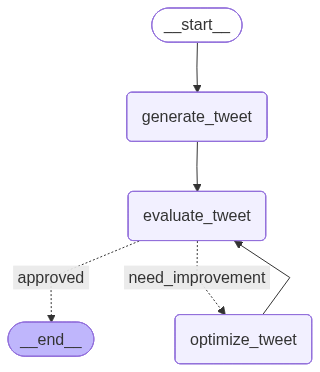

In [24]:
workflow

In [25]:
## Executing
initial_state = {'topic': "AI in IT Sector"}
final_state = workflow.invoke(initial_state)

print(f"Topic- {final_state['topic']}")
print(f"feedback- {final_state['feedback']}")
print(f"evaluation- {final_state['evaluation']}")
# print(f"iteration- {final_state['iteration']}")
# print(f"max_iteration- {final_state['max_iteration']}")

Topic- AI in IT Sector
feedback- The tweet is informative and provides a positive view of AI in the IT sector. It is well-written and does not contain any malicious information or unethical words. However, it could be improved by providing specific examples of AI's impact on the sector.
evaluation- approved
